## <font color="blue">5.1 - Cash Flow - Classification Modeling<font>
---

##### <font color="blue">Imports<font>
---

In [7]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, make_scorer, confusion_matrix, precision_score

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
#Read in file
df = pd.read_parquet('data/cleaned/df_final_3.0.parquet')

df.columns = df.columns.str.replace('<', '')

#Removing of unnecessary columns
bad_corr = ['address', 'city', 'zip', 'apn', 'min_cfp', 'avg_cfp', 'max_cfp', 'min_coc',
            'max_coc', 'min_annual_rent', 'avg_annual_rent', 'max_annual_rent', 'mls_amount', 'mls_date', 'today', 
            'costs', 'est._value', 'total_assessed_value', 'price_per_sqft', 'principal', 'mortgage',
            'avg_coc']         
dfc = df.drop(bad_corr, axis = 1)


#Setting Variables
X = dfc.drop('target_cfp', axis = 1)
y = dfc['target_cfp']



# fit and apply the transform
smtn = SMOTEENN()
X_smoteenn, y_smoteenn = smtn.fit_resample(X, y)


#Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)


In [10]:
df['target_cfp'].value_counts(normalize=True)

0    0.944272
1    0.055728
Name: target_cfp, dtype: float64

##### <font color="blue">Logistic Regression with BayesSearchCV<font>
---

In [11]:
brier_score = make_scorer(brier_score_loss,greater_is_better=False,needs_proba=True)

In [13]:
lr = LogisticRegression(max_iter = 10000)
bayes = BayesSearchCV(lr,scoring=brier_score,
                      search_spaces = {'penalty': Categorical(['l1']),
                                        'solver': Categorical(['saga']),
                                        "C": Real(1e-6, 10, prior='log-uniform')},   
                     cv= 5,
                     n_jobs = -1)
bayes.fit(X_train,y_train)   

BayesSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
              scoring=make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
              search_spaces={'C': Real(low=1e-06, high=10, prior='log-uniform', transform='normalize'),
                             'penalty': Categorical(categories=('l1',), prior=None),
                             'solver': Categorical(categories=('saga',), prior=None)})

In [14]:
pickle.dump(bayes,open('data/Pickles/lr_bayes.pkl', 'wb'))

In [17]:
bayes = pickle.load(open('data/Pickles/lr_bayes.pkl', 'rb'))

pickle.dump(lr_coef_df,open('data/Pickles/lr_coef_df.pkl', 'wb'))


In [16]:
lr_coef_df = pickle.load(open('data/Pickles/lr_coef_df.pkl', 'rb'))

0.2056810516851926
0.20462954171440462
#############################
0.6964130569690952
0.693089430894309


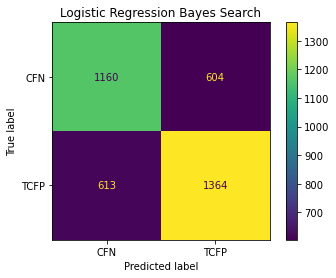

In [28]:
print(-bayes.score(X_train,y_train))
print(-bayes.score(X_test,y=y_test))
print("#############################")
print(precision_score(y_train,bayes.predict(X_train)))
print(precision_score(y_test,bayes.predict(X_test)))


predictions = bayes.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bayes.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['CFN', 'TCFP'])
disp.plot()
plt.title("Logistic Regression Bayes Search")
plt.savefig('Plots/CM.logreg.png',dpi=300, bbox_inches = "tight")

In [19]:
lr_coef_df = pd.DataFrame(data=bayes.best_estimator_.coef_.reshape(-1,1),columns = ['coef'],index = X_train.columns).sort_values(by='coef',ascending=False)
lr_coef_df['odd_ratio'] = lr_coef_df['coef'].apply(math.exp)
lr_coef_df.head(10)

,coef,odd_ratio
median_hh_income_white,0.000038,1.000038
2021_registered_voters,0.000018,1.000018
2020_mail_voters,0.000012,1.000012
"w_hh_income_$75,000_to_$99,999",0.000011,1.000011
"w_hh_income_$25,000_to_$29,999",0.000010,1.000010
population__5-9_years,0.000009,1.000009
"w_hh_income_$40,000_to_$44,999",0.000009,1.000009
"w_hh_income_$35,000_to_$39,999",0.000008,1.000008
population__55-59_years,0.000008,1.000008
population_70-74_years,0.000007,1.000007


In [20]:
r = permutation_importance(bayes,X_test,y_test,scoring='precision')

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test.columns[i]:<8}"
                  f"{r.importances_mean[i]:.5f}"
                  f" +/- {r.importances_std[i]:.3f}")

2021_eligible_to_register0.15006 +/- 0.007
2020_eligible_to_register0.14946 +/- 0.007
2021_total_voters0.13200 +/- 0.006
2021_registered_voters0.12513 +/- 0.005
2020_total_voters0.12289 +/- 0.006
2021_mail_voters0.12187 +/- 0.005
total_income0.11592 +/- 0.006
2020_mail_voters0.11353 +/- 0.006
2020_precinct_voters0.10963 +/- 0.005
female_total_population0.10682 +/- 0.003
passive_income0.10393 +/- 0.005
2020_registered_voters0.10319 +/- 0.003
w_hh_income_$200,000_or_more0.10112 +/- 0.006
population_under_16_years_and_over0.09322 +/- 0.003
active_income0.09233 +/- 0.003
population__5-9_years0.08150 +/- 0.001
population_10-14_years0.07658 +/- 0.003
population_65_years_and_over0.07646 +/- 0.004
population_75_years_and_over0.07438 +/- 0.005
population_30-34_years0.07175 +/- 0.004
population_50-54_years0.07150 +/- 0.003
population_under_18-24_years0.06867 +/- 0.002
se_income0.06354 +/- 0.003
population_over_85_years0.06342 +/- 0.002
population_25-29_years0.06219 +/- 0.004
population__55-59_ye

##### <font color="blue">Random Forest Classifier with BayesSearchCV<font>
---

In [21]:
rf = RandomForestClassifier(n_estimators=600, max_depth=3,min_samples_split=4,
                                       min_samples_leaf=4)
bayes_rf = BayesSearchCV(rf,scoring=brier_score,
                      search_spaces = {'max_features':Integer(30,50)
                        },
                     cv= 3,
                     n_jobs = -1)
bayes_rf.fit(X_train,y_train)

/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: 

BayesSearchCV(cv=3,
              estimator=RandomForestClassifier(max_depth=3, min_samples_leaf=4,
                                               min_samples_split=4,
                                               n_estimators=600),
              n_jobs=-1,
              scoring=make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
              search_spaces={'max_features': Integer(low=30, high=50, prior='uniform', transform='normalize')})

In [22]:
pickle.dump(bayes_rf,open('data/pickles/rf_bayes.pkl', 'wb'))
bayes_rf = pickle.load(open('data/pickles/rf_bayes.pkl', 'rb'))

OrderedDict([('max_features', 50)])
0.14357018158365106
0.14701241109464633
#############################
0.7926336450756264
0.7798334875115633


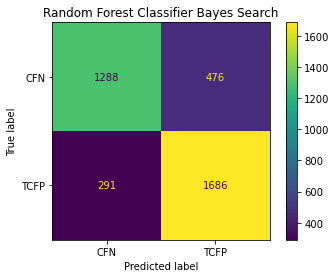

In [29]:
print(bayes_rf.best_params_)
print(-bayes_rf.score(X_train,y_train))
print(-bayes_rf.score(X_test,y_test))
print("#############################")
print(precision_score(y_train,bayes_rf.predict(X_train)))
print(precision_score(y_test,bayes_rf.predict(X_test)))
predictions = bayes_rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bayes_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['CFN', 'TCFP'])
disp.plot()
plt.title("Random Forest Classifier Bayes Search")
plt.savefig('Plots/CM.RF.png',dpi=300, bbox_inches = "tight")



In [24]:
rf_coef_df = pd.DataFrame(data=bayes_rf.best_estimator_.feature_importances_.reshape(-1,1),
                          columns = ['feature_importance'],
                          index = bayes_rf.best_estimator_.feature_names_in_).sort_values(by='feature_importance',ascending=False)

rf_coef_df.head(10)


,feature_importance
bath__3.0,0.217042
median_hh_income_white,0.142016
type__SFR,0.122958
building_sqft,0.089361
2020_turnout_eligible,0.081194
median_age_(years),0.051613
2021_turnout_eligible,0.033364
lot_size_sqft,0.032939
bed__4,0.032821
bed__3,0.021857


In [25]:
r = permutation_importance(bayes_rf,X_test,y_test,scoring='precision')

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test.columns[i]:<8}"
                  f"{r.importances_mean[i]:.5f}"
                  f" +/- {r.importances_std[i]:.3f}")

bath__3.00.06840 +/- 0.006
type__SFR0.02081 +/- 0.002
median_hh_income0.00366 +/- 0.000
bath__4.00.00290 +/- 0.000
median_hh_income_b_aa0.00227 +/- 0.000
effective_year_built0.00139 +/- 0.000
bed__4  0.00100 +/- 0.000


##### <font color="blue">XGB Classifier with BayesSearchCV<font>
---

In [33]:
xgb = XGBClassifier(n_estimators = 187,max_depth=2,min_child_weight=2,gamma = 0.7,max_leaves = 2)
bayes_xgb = BayesSearchCV(xgb,scoring=brier_score,
                      search_spaces = {'learning_rate':Real(.05,.2)},
                    cv= 3,
                    n_jobs = -1,
                    verbose=True)
bayes_xgb.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/preetsekhon/opt/anaconda3/envs/DSI/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=0.7, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None,...
                                      max_leaves=2, min_child_weight=2,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=187, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, ...),
              n_jobs=-1,
              scoring=make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
              search_spaces={'learning_rate': Real(low=0.05, high=0.2, prior='uniform', transform='normalize')},
              verbose=True)

In [31]:
#pickle.dump(bayes_xgb,open('../data/pickles/xgb_bayes.pkl', 'wb'))
bayes_xgb = pickle.load(open('../data/pickles/xgb_bayes.pkl', 'rb'))

OrderedDict([('learning_rate', 0.199706731543767)])
0.044695389560692265
0.047302021122134316
#############################
0.9636481241914618
0.9551148225469729


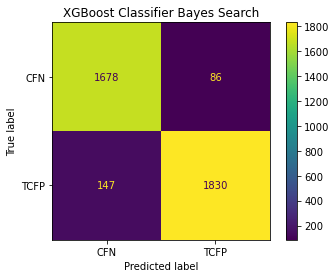

In [34]:
print(bayes_xgb.best_params_)
print(-bayes_xgb.score(X_train,y_train))
print(-bayes_xgb.score(X_test,y_test))
print("#############################")
print(precision_score(y_train,bayes_xgb.predict(X_train)))
print(precision_score(y_test,bayes_xgb.predict(X_test)))
predictions = bayes_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bayes_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['CFN', 'TCFP'])
disp.plot()
plt.title("XGBoost Classifier Bayes Search")
plt.savefig('Plots/CM.XGB.png',dpi=300, bbox_inches = "tight")


In [ ]:
xbg_coef_df = pd.DataFrame(data=bayes_xgb.best_estimator_.feature_importances_.reshape(-1,1),columns = ['feature_importance'],index = bayes_xgb.best_estimator_.feature_names_in_).sort_values(by='feature_importance',ascending=False)
xbg_coef_df.head(10)

,feature_importance
median_hh_income_white,0.094715
bath__3.0,0.072193
status__PENDING,0.063546
status__ACTIVE,0.057477
type__SFR,0.054789
median_hh_income,0.048991
2020_turnout_eligible,0.045324
child_dependency_ratio,0.042329
county__Riverside,0.035299
bath__2.0,0.033343


In [ ]:
r = permutation_importance(bayes_xgb,X_test,y_test,scoring='precision')

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test.columns[i]:<8}"
                  f"{r.importances_mean[i]:.5f}"
                  f" +/- {r.importances_std[i]:.3f}")

status__ACTIVE0.11937 +/- 0.004
status__PENDING0.10288 +/- 0.003
bath__2.00.08497 +/- 0.004
bed__3  0.07835 +/- 0.001
bath__3.00.07490 +/- 0.002
bed__2  0.04702 +/- 0.000
bed__4  0.04202 +/- 0.002
building_sqft0.03935 +/- 0.004
type__SFR0.03261 +/- 0.001
status__CONTINGENT0.02812 +/- 0.001
bath__1.00.02231 +/- 0.001
bed__1  0.01128 +/- 0.001
bath__4.00.00830 +/- 0.001
lot_size_sqft0.00646 +/- 0.002
type__Condo0.00420 +/- 0.000
bed__5  0.00411 +/- 0.001
effective_year_built0.00274 +/- 0.001
dom     0.00200 +/- 0.001
bath__2.50.00108 +/- 0.000
old-age_dependency_ratio0.00084 +/- 0.000


In [ ]:
print(-bayes.score(X_train,y_train))
print(-bayes.score(X_test,y=y_test))
print(precision_score(y_train,bayes.predict(X_train)))
print(precision_score(y_test,bayes.predict(X_test)))

print(-bayes_rf.score(X_train,y_train))
print(-bayes_rf.score(X_test,y_test))
print(precision_score(y_train,bayes_rf.predict(X_train)))
print(precision_score(y_test,bayes_rf.predict(X_test)))

print(-bayes_xgb.score(X_train,y_train))
print(-bayes_xgb.score(X_test,y_test))
print(precision_score(y_train,bayes_xgb.predict(X_train)))
print(precision_score(y_test,bayes_xgb.predict(X_test)))

0.2071378829249076
0.20238801411680568
0.6956789363535639
0.7101879327398615
0.14607556827563922
0.14582353279340157
0.7918775885872066
0.7922971114167813
0.04465348545006822
0.047191090205547674
0.9627960865087538
0.9490670700958144
